In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
from scipy.optimize import minimize
from joblib import Parallel, delayed
import time as t
from scipy.linalg import sqrtm, inv, eigh, expm, expm_frechet

In [55]:
#Control Hamiltonian
def H(phi=[], beta=1, omega=1, J=1, w = []):
    H_array = np.array([omega*(np.cos(phi[i])*J_x+np.sin(phi[i])*J_y)+ beta/(2*J) * J_z2 + w[0]*J_x + w[1]*J_y + w[2]*J_z for i in range(len(phi))])
    return H_array

#Parameters
rng = np.random.default_rng()
J = 20
dim = int(2*J+1)
t_steps = 7000
delta_t = 0.001
beta = 1
omega = 1
w = [0.1, -0.2, 0.15]
sn_sd = 1/np.sqrt(100000 * delta_t)
gtol = 1e-5
theta_scs = np.pi/2
phi_scs = 0
J_x = spin_Jx(J).full()
J_y = spin_Jy(J).full()
J_z = spin_Jz(J).full()
J_z2 = J_z @ J_z
obs_0 = J_y

if np.array_equal(obs_0, J_x):
    obs_0_string = 'J_x'
elif np.array_equal(obs_0, J_y):
    obs_0_string = 'J_y'
elif np.array_equal(obs_0, J_z):
    obs_0_string = 'J_z'
else:
    obs_0_string = 'unknown'


evolution_time = [t_step * delta_t for t_step in range(t_steps+1)]
in_state = spin_coherent(J, theta_scs, phi_scs, type = 'dm').full()

def commutator(A, B):
   """Compute the commutator [A, B] = AB - BA."""
   return A @ B - B @ A

def expect(obs, state):
    """Compute the expectation value of an observable."""
    return np.real(np.trace(obs @ state))

def fidelity(rho, sigma):
    # Compute sqrt(rho)
    sqrt_rho = sqrtm(rho)
    # Compute sqrt_rho * sigma * sqrt_rho
    inner = sqrt_rho @ sigma @ sqrt_rho
    # Compute sqrt of the inner matrix
    sqrt_inner = sqrtm(inner)
    # Take the trace and square the result
    fidelity_value = np.real(np.trace(sqrt_inner)) ** 2
    return fidelity_value

def bloch_vector_norm(state_array):
    bloch_norm = np.zeros(t_steps + 1)
    for i in range(t_steps+1):
        n = 1/J * np.array([expect(J_x, state_array[i]), expect(J_y, state_array[i]), expect(J_z, state_array[i])])
        bloch_norm[i] = np.linalg.norm(n)
    return bloch_norm

def obj(w, M_vec):
    H_array = H(phi, beta, omega, J, w)
    obs_array = [None] * (t_steps + 1)
    obs = obs_0
    obs_array[0] = obs
    for i in range(t_steps):
        U = expm(-1j * delta_t * H_array[i])
        obs = U.conj().transpose() @ obs @ U
        obs_array[i+1] = obs
    obs_trace = np.array([expect(obs_array[i], in_state) for i in range(t_steps+1)])
    norm = np.linalg.norm(M_vec - obs_trace)
    return norm


def w_estimate(gaussian_noise, expectation, w_init):
    M_vec = expectation + gaussian_noise
    optimization = minimize(obj, x0=w_init, args = (M_vec,), method='BFGS', options={'gtol': gtol})
    return optimization


In [ ]:
w_init = [0, 0, 0]
batch_size = 50
iter = 600
beta_array = np.array([1])
runs = len(beta_array)
runtime_array = np.zeros(runs)
covar_array = [None] * runs
mean_array = [None] * runs
std_array = [None] * runs
fisher_array = [None] * runs
w_est_all_runs = [None] * runs
w_est_dict_failures = [None] * runs
norm_array = [None] * runs
bias = [None] * runs
CRB_diff_eig = [None] * runs
fisher_shannon_entropy = [None] * runs

for k in range(runs):
    start_time = t.time()
    shannon = []
    w_est = []
    failures = []
    beta = beta_array[k]
    phi = 2*np.pi*rng.random(t_steps)
    H_array = H(phi, beta, omega, J, w)
    U_array = [expm(-1j * delta_t * H_array[i]) for i in range(t_steps)]
    U_dagger_array = [U_array[i].conj().transpose() for i in range(t_steps)]

    #Calculate expectation value
    obs_array = [None] * (t_steps + 1)
    obs = obs_0
    obs_array[0] = obs
    for i in range(t_steps):
        obs = U_dagger_array[i] @ obs @ U_array[i]
        obs_array[i+1] = obs
    expectation = np.array([expect(obs_array[i], in_state) for i in range(t_steps+1)])

    #Calculate state evolution
    # state_array = [None] * (t_steps + 1)
    # state = in_state
    # state_array[0] = state
    # for i in range(t_steps):
    #     state = U_array[i] @ state @ U_dagger_array[i]
    #     state_array[i+1] = state

    #Calculate bloch vector norm
    #norm_array[k] = bloch_vector_norm(state_array)
    
    #Calculate fisher information
    del_obs_array_x = [None] * t_steps
    del_obs_x = expm_frechet(1j*delta_t*H_array[0], 1j*delta_t*J_x, compute_expm=False) @ obs_array[0] @ U_array[0] + U_dagger_array[0] @ obs_array[0] @ expm_frechet(-1j*delta_t*H_array[0], -1j*delta_t*J_x, compute_expm=False)
    del_obs_array_x[0] = del_obs_x
    for i in range(1, t_steps):
        del_obs_x = expm_frechet(1j*delta_t*H_array[i], 1j*delta_t*J_x, compute_expm=False) @ obs_array[i] @ U_array[i] + U_dagger_array[i] @ obs_array[i] @ expm_frechet(-1j*delta_t*H_array[i], -1j*delta_t*J_x, compute_expm=False) + U_dagger_array[i] @ del_obs_x @ U_array[i]
        del_obs_array_x[i] = del_obs_x
    del_expect_x = np.array([expect(del_obs_array_x[i], in_state) for i in range(t_steps)])

    del_obs_array_y = [None] * t_steps
    del_obs_y = expm_frechet(1j*delta_t*H_array[0], 1j*delta_t*J_y, compute_expm=False) @ obs_array[0] @ U_array[0] + U_dagger_array[0] @ obs_array[0] @ expm_frechet(-1j*delta_t*H_array[0], -1j*delta_t*J_y, compute_expm=False)
    del_obs_array_y[0] = del_obs_y
    for i in range(1, t_steps):
        del_obs_y = expm_frechet(1j*delta_t*H_array[i], 1j*delta_t*J_y, compute_expm=False) @ obs_array[i] @ U_array[i] + U_dagger_array[i] @ obs_array[i] @ expm_frechet(-1j*delta_t*H_array[i], -1j*delta_t*J_y, compute_expm=False) + U_dagger_array[i] @ del_obs_y @ U_array[i]
        del_obs_array_y[i] = del_obs_y
    del_expect_y = np.array([expect(del_obs_array_y[i], in_state) for i in range(t_steps)])

    del_obs_array_z = [None] * t_steps
    del_obs_z = expm_frechet(1j*delta_t*H_array[0], 1j*delta_t*J_z, compute_expm=False) @ obs_array[0] @ U_array[0] + U_dagger_array[0] @ obs_array[0] @ expm_frechet(-1j*delta_t*H_array[0], -1j*delta_t*J_z, compute_expm=False)
    del_obs_array_z[0] = del_obs_z
    for i in range(1, t_steps):
        del_obs_z = expm_frechet(1j*delta_t*H_array[i], 1j*delta_t*J_z, compute_expm=False) @ obs_array[i] @ U_array[i] + U_dagger_array[i] @ obs_array[i] @ expm_frechet(-1j*delta_t*H_array[i], -1j*delta_t*J_z, compute_expm=False) + U_dagger_array[i] @ del_obs_z @ U_array[i]
        del_obs_array_z[i] = del_obs_z
    del_expect_z = np.array([expect(del_obs_array_z[i], in_state) for i in range(t_steps)])

    for j in np.arange(0, t_steps+1, 10):
        del_expectation_x = del_expect_x[:j]
        del_expectation_y = del_expect_y[:j]
        del_expectation_z = del_expect_z[:j]
        fisher_matrix = np.zeros((3, 3))
        fisher_matrix[0, 0] = np.vdot(del_expectation_x, del_expectation_x) / sn_sd**2
        fisher_matrix[1, 1] = np.vdot(del_expectation_y, del_expectation_y) / sn_sd**2
        fisher_matrix[2, 2] = np.vdot(del_expectation_z, del_expectation_z) / sn_sd**2
        fisher_matrix[0, 1] = np.vdot(del_expectation_x, del_expectation_y) / sn_sd**2
        fisher_matrix[0, 2] = np.vdot(del_expectation_x, del_expectation_z) / sn_sd**2
        fisher_matrix[1, 2] = np.vdot(del_expectation_y, del_expectation_z) / sn_sd**2
        fisher_matrix[1, 0] = fisher_matrix[0, 1]
        fisher_matrix[2, 0] = fisher_matrix[0, 2]
        fisher_matrix[2, 1] = fisher_matrix[1, 2]
        fisher_eig = np.linalg.eigvals(fisher_matrix)
        fisher_eig = fisher_eig/np.sum(fisher_eig)
        shannon.append(-np.sum(fisher_eig * np.log(fisher_eig)))
    fisher_shannon_entropy[k] = np.array(shannon)
    print(f'Run {k+1} complete.')
    #fisher_array[k] = fisher_matrix


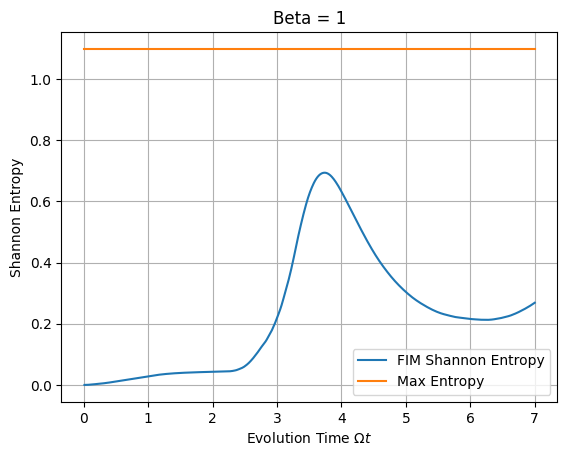

In [57]:
for i in range(runs):
    plt.plot(delta_t * np.arange(0, t_steps+1, 10), fisher_shannon_entropy[i], label='FIM Shannon Entropy')
    plt.plot(delta_t * np.arange(0, t_steps+1, 10), np.full(fisher_shannon_entropy[i].shape, np.log(3)), label='Max Entropy')
    plt.xlabel('Evolution Time $\Omega t$')
    plt.ylabel('Shannon Entropy')
    plt.legend()
    plt.title(f'Beta = {beta_array[i]}')
    plt.grid()
    plt.show()

In [43]:
folder = "data_"

parameters = (
    f"Parameters: J = {J}; beta = {beta:.3f}; omega = {omega}; w = {w}; sn_sd = {sn_sd:.3f}; "
    f"delta_t = {delta_t}; t_steps = {t_steps}; iter = {iter}; "
    f"Initial state: theta_scs = {theta_scs:.3f}; phi_scs = {phi_scs:.3f}; Initial observable = {obs_0_string}"
)
with open(f"C:/Users/alexg/OneDrive/Docs/UNM/Ivan Research/VSCode/Jupyter/FIM shannon entropy/parameters.txt", "w") as f:
    f.write(parameters)


In [ ]:

np.save(f"/users/agarcia2001/{folder}/mean_array.npy", mean_array)
np.save(f"/users/agarcia2001/{folder}/bias.npy", bias)
np.save(f"/users/agarcia2001/{folder}/std_array.npy", std_array)
np.save(f"/users/agarcia2001/{folder}/beta_array.npy", beta_array)
np.save(f"/users/agarcia2001/{folder}/covar_array.npy", covar_array)
np.save(f"/users/agarcia2001/{folder}/fisher.npy", fisher_array)
np.save(f"/users/agarcia2001/{folder}/runtime.npy", runtime_array)
np.save(f"/users/agarcia2001/{folder}/w_est_all_runs.npy", np.array(w_est_all_runs))
np.save(f"/users/agarcia2001/{folder}/fidelity.npy", fidelity_values)
np.save(f"/users/agarcia2001/{folder}/norm_array.npy", norm_array)
np.save(f"/users/agarcia2001/{folder}/evolution_time.npy", evolution_time)
np.save(f"/users/agarcia2001/{folder}/fisher_inv_trace.npy", fisher_inv_trace)
np.save(f"/users/agarcia2001/{folder}/covar_trace.npy", cov_array_trace)
np.save(f"/users/agarcia2001/{folder}/CRB_diff_eig.npy", CRB_diff_eig)
with open(f"/users/agarcia2001/{folder}/parameters.txt", "w") as f:
    f.write(parameters)
with open(f"/users/agarcia2001/{folder}/w_est_failures.txt", "w") as f:
    f.write(str(w_est_dict_failures))



